# K-Means To Categorize Customers According To Shopping Trends

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
cust_df = pd.read_csv('OnlineRetail.csv', sep=',', encoding='iso-8859-1')
cust_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
cust_df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


### EDA

check for any missing values 

In [5]:
cust_df.shape

(541909, 8)

In [6]:
cust_df.isna().sum()/cust_df.shape[0]*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

The <b>CustomerID</b> represents 24.93% of the data. We can drop this column since it is a column that identifies a unique customer.

## Data manipulation

<b>CustomerID</b> is represented as a float but wwe want it to be a string value

In [7]:
cust_df['CustomerID'] = cust_df['CustomerID'].astype(str)

The <b>InvoiceDate</b> is represented as an object but to perform datetime operations on it later we need to convert it into a datetime column

In [8]:
cust_df['InvoiceDate'] = pd.to_datetime(cust_df['InvoiceDate'], format='%d-%m-%Y %H:%M')



We are going to use group customers according to:

    1. the amount they spent shopping (amount). 
    2. the number of times they shopped (frequency)
    3. how long it has been since their last order (recency)

#### Amount

In [9]:
# create a new column Amount by multiplying the unit price of each item by the quantity purchased
cust_df['Amount'] = cust_df['Quantity']*cust_df['UnitPrice']
# create a new dataframe that represents the total sum used by each customer represented by a unique ID
amnt_df = cust_df.groupby('CustomerID')['Amount'].sum().reset_index()

#### Frequency

In [10]:
# for each purchase an invoice is generated. By counting the number of invoices each customer has been 
# issue then we can determine how many times the customer shopped in the store.
#  we then assign this to a new dataframe
freq_df = cust_df.groupby('CustomerID')['InvoiceNo'].count().reset_index()

#### Recency

In [11]:
# first we get the most recent date 
recent_date = cust_df['InvoiceDate'].max()
# create a new column 
cust_df['DaysSinceLastOrder'] = recent_date - cust_df['InvoiceDate']
# group the by customerID and get the minimum time for each customer. Assign this to a new dataframe rec_df
rec_df = cust_df.groupby('CustomerID')['DaysSinceLastOrder'].min().dt.days.reset_index()

Joining the three new dataframes we created on CustomerID to create on dataframe we will use for modelling

In [12]:
amnt_freq_df = pd.merge(amnt_df, freq_df, on='CustomerID', how='inner')
cust_model_df = pd.merge(amnt_freq_df, rec_df, on='CustomerID', how='inner')
cust_model_df.columns = ['CustomerID','Amount','Frequency','Recency']
cust_model_df.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


#### visualize the data using a boxplot to detect outliers

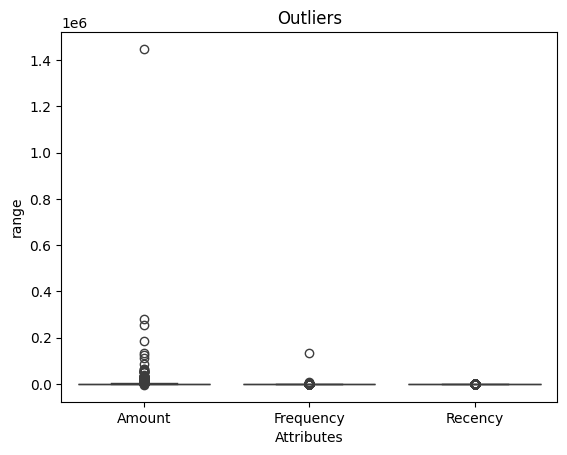

In [13]:
sns.boxplot(data=cust_model_df[['Amount','Frequency','Recency']])
plt.title('Outliers')
plt.ylabel('range')
plt.xlabel('Attributes')
plt.show()

In [14]:
# from scipy.stats.mstats import winsorize

In [15]:
cols = ['Amount','Frequency','Recency']
# for col in cols:
#     cust_model_df[col] = winsorize(cust_model_df[col], limits=[0.15,0.15])


Remove **Amount** outliers

In [16]:
Q1 = cust_model_df['Amount'].quantile(0.05)
Q3 = cust_model_df['Amount'].quantile(0.95)
IQR = Q3 -Q1
X = 1.5*IQR
cust_model_df = cust_model_df[(cust_model_df['Amount']>=Q1-X) & (cust_model_df['Amount']<=Q3+X)]

Remove **Frequency** outliers

In [17]:
Q1 = cust_model_df['Frequency'].quantile(0.05)
Q3 = cust_model_df['Frequency'].quantile(0.95)
IQR = Q3 -Q1
X = 1.5*IQR
cust_model_df = cust_model_df[(cust_model_df['Frequency']>=Q1-X) & (cust_model_df['Frequency']<=Q3+X)]

Remove **Recency** outliers

In [18]:
Q1 = cust_model_df['Recency'].quantile(0.05)
Q3 = cust_model_df['Recency'].quantile(0.95)
IQR = Q3 -Q1
X = 1.5*IQR
cust_model_df = cust_model_df[(cust_model_df['Recency']>=Q1-X) & (cust_model_df['Recency']<=Q3+X)]

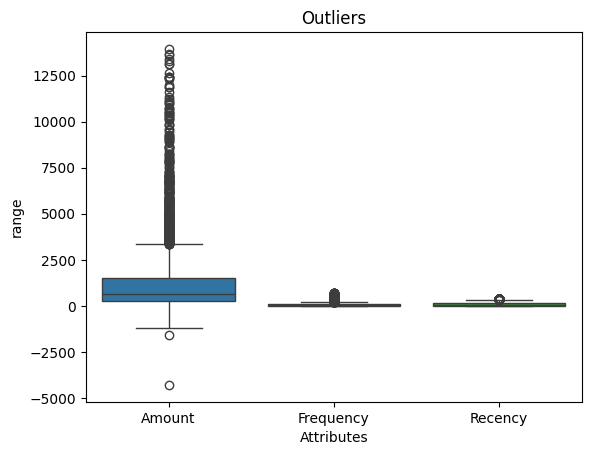

In [19]:
sns.boxplot(data=cust_model_df[['Amount','Frequency','Recency']])
plt.title('Outliers')
plt.ylabel('range')
plt.xlabel('Attributes')
plt.show()

In [20]:
cust_model_df.shape

(4294, 4)

#### Scaling dataset

In [21]:
from sklearn.preprocessing import StandardScaler

In [22]:
scaler = StandardScaler()
cust_model_df =  cust_model_df[cols]
for col in cols:
    cust_model_df[col] = scaler.fit_transform(cust_model_df[[col]])
print(cust_model_df.shape)
cust_model_df.head()

(4294, 3)


,Amount,Frequency,Recency
0,-0.721139,-0.753083,2.301868
1,1.719726,1.041594,-0.906269
2,0.296685,-0.463941,-0.183448
3,0.274207,-0.045183,-0.737941
4,-0.531759,-0.603527,2.143441


## model

In [23]:
from sklearn.cluster import KMeans

Finding the best possible value of K using the elbow method

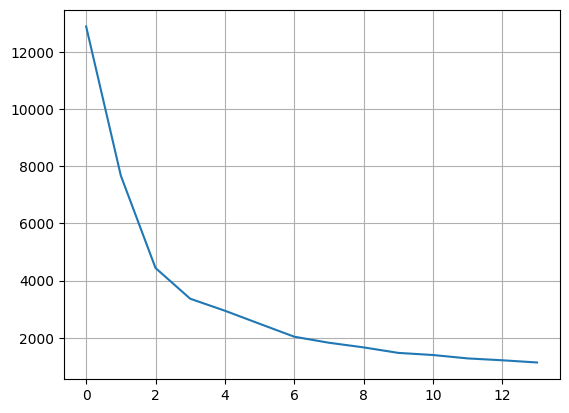

In [24]:
ssd = []
for i in range(1,15):
    kmeans = KMeans(n_clusters=i,random_state=42,n_init='auto')
    kmeans.fit(cust_model_df)
    ssd.append(kmeans.inertia_)

plt.plot(ssd)
plt.grid()
plt.show()

From the graph above we can choose **3** as the optimal value for k

In [25]:
kmeans = KMeans(n_clusters=3, n_init='auto')
kmeans.fit(cust_model_df[cols])

KMeans(n_clusters=3, n_init='auto')

In [26]:
kmeans.labels_

array([1, 0, 2, ..., 1, 2, 2], dtype=int32)

In [27]:
cust_model_df['Label'] = kmeans.labels_
cust_model_df

,Amount,Frequency,Recency,Label
0,-0.721139,-0.753083,2.301868,1
1,1.719726,1.041594,-0.906269,0
2,0.296685,-0.463941,-0.183448,2
3,0.274207,-0.045183,-0.737941,2
4,-0.531759,-0.603527,2.143441,1
...,...,...,...,...
4366,-0.622655,-0.683290,-0.193350,2
4367,-0.618860,-0.673320,1.826588,1
4368,-0.675368,-0.703231,0.866128,1
4369,-0.621126,-0.643408,-0.846859,2


<Axes: xlabel='Label', ylabel='Amount'>

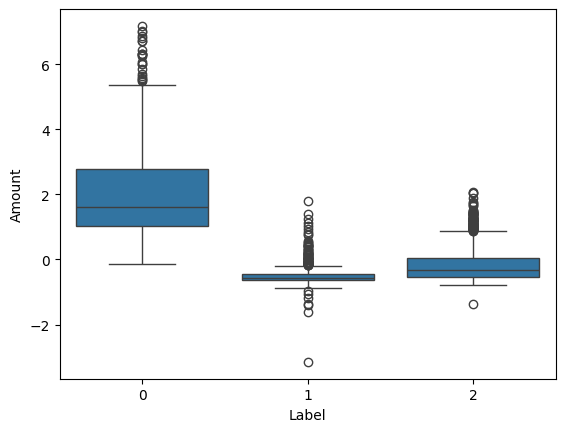

In [28]:
sns.boxplot(x='Label', y='Amount', data=cust_model_df)

<Axes: xlabel='Label', ylabel='Frequency'>

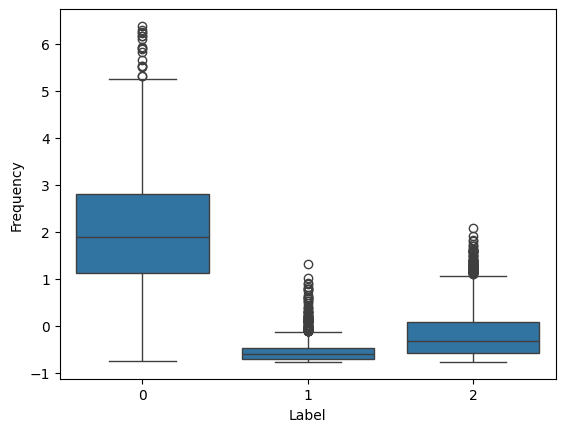

In [29]:
sns.boxplot(x='Label', y='Frequency', data=cust_model_df)

<Axes: xlabel='Label', ylabel='Recency'>

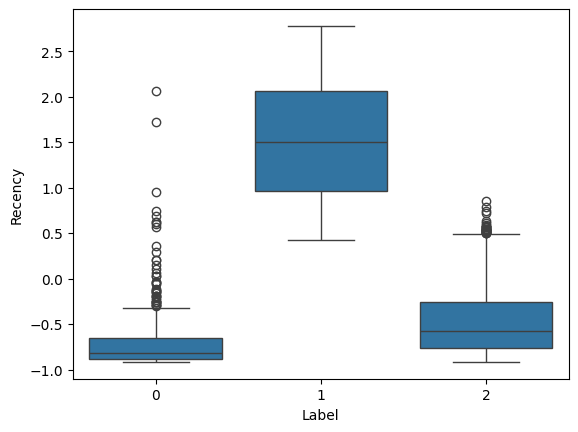

In [30]:
sns.boxplot(x='Label', y='Recency', data=cust_model_df)